# Machine Learning in Python - Project 2

Due Friday, April 15th by 5 pm UK local time.

Contributors: Letian Yin(s2179686), Yile Shi(s2168022), Danni Chen(s2227278)

## 0. Setup

In [1]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

from scipy.stats.distributions import uniform, loguniform

# sklearn modules
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score

import os
from google.colab import drive

In [2]:
import graphviz 

In [3]:
# Load data
drive.mount('/content/drive') # give permission
os.chdir('drive/My Drive/Colab Notebooks/ML for python/project 2')
#os.chdir('drive/My Drive/Colab Notebooks/mlp/project-2')
d = pd.read_csv("hotel.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Introduction

The target of this project is to research the potential factors that affect the cancellation of booking in hotel. The data is derived from the booking systems of two real hotels, and the records are from July 1st, 2015 to August 31st, 2017. This is a large dataset, containing 29 variables and 119,390 observations; it also is a messy dataset, and it can contain errors.
We started our project with data cleaning, data exploration, followed by feature selection and feature engineering. 

Model is built with Decision Tree method, with several refinements on feature selection and parameter optimization, we ended up with a model with max_depth 7, gini criterion, 46 min_samples_leaf, and with “best” option as the splitter. The most important feature are listed below in the order of their importance, from high to low:


`Non_Refund`, `lead_time`, `country_prt` and `reserved_equal_assigned`, `total_of_special_requests`, `booking_changes_class`, `adults`.

And we could conclude that these feature has a higher weight of effect on the probability of cancelling the booking `is_cancelled`.



## 2. Exploratory Data Analysis and Feature Engineering

As we have a total of 29 features in the beginning, we first did some data cleaning and feature preprocessing.

In [4]:
df = d.copy()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            


### 2.1 Data Cleaning

Before feature selection and data preprocessing, we explored deeply into the raw data first, and found some improper data based on the realistic logic. Specifically, we deleted some data according to the following criteria:

  - The variable `repeated_guest` marked as 0 should have no previous booking.
  
  - Average daily rate `adr` should have a reasonable value (non-negative and no more than 1000).
  
  - The number of car parking spaces required should be no more than the number of adults.
  
Moreover, missing values of categorical variables, i.e., `country`, `distribution_channel`, are deleted, as they occupy small proportions.

As for the numerical variable `children` with a small amount of missing values, it was imputed by its mean value.

In [5]:
# drop observations with no previous booking but considered as repeated guest
drop_idx_1 = df.loc[(df['is_repeated_guest'] == 0) & (df['previous_bookings_not_canceled'] > 0)].index
df.drop(index = drop_idx_1, inplace = True)

In [6]:
# drop observations with improper values
drop_idx_2 = df.loc[(df['adr'] < 0) | (df['adr'] > 1000)].index
df.drop(index = drop_idx_2, inplace = True)

In [7]:
# drop observations with required car parking spaces over the number of adults
drop_idx_3 = df.loc[df['required_car_parking_spaces'] > df['adults']].index
df.drop(index = drop_idx_3, inplace = True)

In [8]:
# drop observations where country is missing
drop_idx_4 = df.loc[df['country'].isna() == True].index
df.drop(index = drop_idx_4, inplace = True)

In [9]:
# drop observations with undefined market segment
drop_idx_5 = df.loc[df['distribution_channel'] == 'Undefined'].index
df.drop(index = drop_idx_5, inplace = True)

In [10]:
# impute missing values in children by its mean
df['children'] = df['children'].fillna(df['children'].mean())

### 2.2 Feature Preprocessing

### 2.2.1 Features converted into binary class 

For feature `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number`,and `arrival_date_day_of_month`, as these four features have similar properties, we analyzed the cancellation proportion by grouping each of these features, tried if the feature has an overall effect on the cancellation probability. After analysis, the cancellation proportion of `arrival_date_year` does not have a clear trend, the cancellation proportion of `arrival_date_week_number` varies largely between weeks, and we cannot distinguish a clear trend from it, and the cancellation proportion of `arrival_date_day_of_month` is also uninformative. 

However, it seems that the cancellation proportion of `arrival_date_month` has a difference that we can easily distinguish: ***April--October*** are high, while ***November--March*** are low, so we decided to drop the other three features, and kept `arrival_date_month` only. April~October are assigned 1 (cancellation percentage = 0.393), and November--March are assigned 0 (cancellation percentage = 0.329).

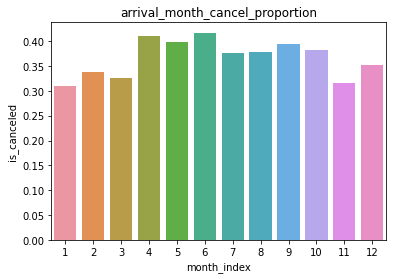

In [11]:
# histogram for cancellation proportion of each month
arrival_month_cancel_proportion = df.groupby(['arrival_date_month'])['is_canceled'].sum('is_canceled')/df.groupby(['arrival_date_month'])['is_canceled'].count()
month_df = arrival_month_cancel_proportion.to_frame().reset_index()
month_df['month_index'] = [4,8,12,2,1,7,6,3,5,11,10,9]
sns.barplot(x = month_df['month_index'], y = month_df['is_canceled']).set(title='arrival_month_cancel_proportion')
plt.show()

In [12]:
# convert month to binary - 4-10 : 1, others : 0
df['month_class'] = df['arrival_date_month'].apply(lambda x:int(x in ['April', 'May', 'June', 'July', 'August', 'September', 'October']))

Initially looking at the dataset, the two hotels are both located in Portugal, and PRT has over 45000 rows of data, accounts nearly half of the dataset. Also, guests from Portugal have more information and convenience, and thus are more likely to change or cancel the hotel booking compared to those from abroad. Therefore, we listed PRT out, assigned as 1, and we assigned the rest as 0. 

New feature name is called `country_prt`. We can tell the cancellation percentage of PRT is 0.571, and the cancellation percentage of non-PRT is 0.237.

In [13]:
# convert country to binary - PRT : 1, non-PRT : 0
df['country_prt'] = df['country'].apply(lambda x:int(x=='PRT'))
# cancellation proportion for each class
print(df.groupby(['country_prt'])['is_canceled'].sum()/df.groupby(['country_prt'])['is_canceled'].count())

country_prt
0    0.237155
1    0.570577
Name: is_canceled, dtype: float64


We did similar approach to `hotel`, `distribution_channel`, `previous_cancellations_class`, `reserved_equal_assigned`, `booking_changes_class`, `days_in_waiting_list`, `required_car_parking_spaces_class`.

---

At first, we looked at the `hotel` feature, as we think guests who booked hotels in the city has a higher probability to cancel, because they have more choices in the city, and city is assigned as 1 (cancellation percentage=0.418), resort is assigned 0 (cancellation percentage=0.282).

In [14]:
# convert hotel to binary - city : 1, resort : 0
df['hotel_class'] = df['hotel'].apply(lambda x:int(x=='City Hotel'))

---

The cancellation percentage of `distribution_channel` is displayed below, where TA/TO has an extremely high cancellation rate, therefore we assigned TA/TO as 1 (cancellation percentage=0.411), and we assigned the rest as 0 (cancellation percentage=0.193).

In [15]:
# convert distribution channel to binary - TA/TO : 1, non-TA/TO : 0
df['distribution_channel_class'] = df['distribution_channel'].apply(lambda x:int(x=='TA/TO'))

---

For data with `previous_cancellations_class`, we think guests who had cancelled the booking before has a higher probability of cancelling it again, so we converted them into two groups: guests with no previous cancellation (cancellation percentage=0.341, assigned as 0), and guests who cancelled (cancellation percentage=0.926, assigned as 1). 

In [16]:
# convert previous_cancellations_class to binary - non-zero : 1, zero : 0
df['previous_cancellations_class'] = df['previous_cancellations'].apply(lambda x:int(x!=0))

---

We checked if the `reserved_room_type` is the same as the `assigned_room_type`. If they were different, the hotel usually assigned an advanced level of room for the guest because the hotel was out of the type they booked, and we think this has a potential effect on cancellation rate, as guests who received an advanced service using less money are less likely to cancel the booking. Match is assigned as 1 (cancellation percentage=0.417), and non-match is assigned as 0 (cancellation percentage=0.054), and the new feature is called `reserved_equal_assigned`.

In [17]:
# create a new binary column for reserved and assigned - matching : 1, non-matching : 0
df['reserved_equal_assigned'] = np.where((df['reserved_room_type'] == df['assigned_room_type']), 1, 0)

---

Guests who never changed their booking take most amount of the dataset. We think guests who changed the booking try to better satisfy their requirements, so they will be less likely to cancel the booking. Therefore, we converted them and assigned `never changed` as 0 (cancellation percentage=0.411), and `changed` as 1(cancellation percentage=0.158), and the new feature is called `booking_changes_class`.

In [18]:
# convert booking_changes to binary - changed : 1, non-changed : 0
df['booking_changes_class'] = df['booking_changes'].apply(lambda x:int(x!=0))

---

Based on the analysis of its graph we had plotted, we cannot tell the difference of cancellation percentage of different days_in_waiting_list. So we considered it in general. guests who have a longer waiting time tends to have a higher probability of cancelling the booking than guests who do not need to wait. So we also converted this feature, assigned them as either have days in waiting list as 1 (cancellation percentage=0.64), or not as 0 (cancellation percentage=0.368), and the new feature is called “have_days_in_wl”.

In [19]:
# convert this column to binary - wait : 1, non-wait : 0
df['have_days_in_wl'] = np.where((df['days_in_waiting_list'] != 0), 1, 0)

---

For guests who required car parking spaces, we guessed they will have a smaller probability of cancelling the booking as their requirements have been satisfied. We converted this feature into either they need car_parking spaces as 1 (cancellation percentage=0), or not as 0 (cancellation percentage=0.404). Note that when guests asking for car parking spaces, none of them cancelled the booking.

In [20]:
# covert required_car_parking_spaces to binary - required : 1, non-required : 0
df['required_car_parking_spaces_class'] = df['required_car_parking_spaces'].apply(lambda x:int(x!=0))

### 2.2.2 Features one-hot encoded

The cancellation percentage for different `customer types` varies differently, so we directly applied one hot encoding on it. The cancellation percentage of `Contract`, `Group`, `Transient`, `Transient-Party` are 0.31, 0.109, 0.419, 0.259 respectively.

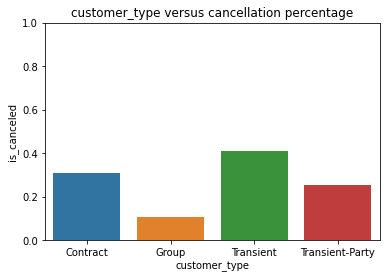

customer_type
Contract           0.309769
Group              0.108779
Transient          0.410609
Transient-Party    0.254727
Name: is_canceled, dtype: float64


In [21]:
# histograms for cancellation proportion for each customer type
cust_type = df.groupby(['customer_type'])['is_canceled'].sum()/df.groupby(['customer_type'])['is_canceled'].count()
cust_type_df = cust_type.to_frame().reset_index()
sns.barplot(x=cust_type_df['customer_type'], y=cust_type_df['is_canceled']).set(title='customer_type versus cancellation percentage', ylim=(0,1))
plt.show()
print(df.groupby(['customer_type'])['is_canceled'].sum()/df.groupby(['customer_type'])['is_canceled'].count())

# one hot encoding for customer type
onehot = OneHotEncoder(handle_unknown='ignore')
cus_encoded = onehot.fit_transform(np.array(df['customer_type']).reshape(-1, 1))
cus_encoded_df = pd.DataFrame(cus_encoded.toarray(), columns = ['Contract', 'Group', 'Transient', 'Transient-Party'])
df = pd.merge(df, cus_encoded_df, left_index = True, right_index = True)

---

We did similar application on `deposit_type`, and the cancellation percentage of `No Deposit`, `Non Refund`, `Refundable` are 0.292, 0.994, 0.224 respectively.

In [22]:
# one hot encoding for deposit type
onehot = OneHotEncoder(handle_unknown='ignore')
dep_encoded = onehot.fit_transform(np.array(df['deposit_type']).reshape(-1, 1))
dep_encoded_df = pd.DataFrame(dep_encoded.toarray(), columns = ['No_Deposit', 'Non_Refund', 'Refundable'])
df = pd.merge(df, dep_encoded_df, left_index = True, right_index = True)

### 2.2.3 Features without processing

We did not apply any changes to `is_repeated_guest`, `total_of_special_requests`, `lead_time`, and directly used them in our model.

For example, as the graph shown below, the cancellation percentage tends to decrease as the number of special requests increase.

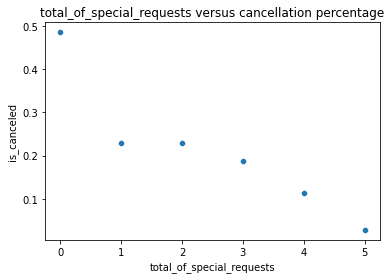

In [23]:
# scatter plot for cancellation proportion over number of special requests
special_req = df.groupby('total_of_special_requests')['is_canceled'].sum()/df.groupby(['total_of_special_requests'])['is_canceled'].count()
special_req = special_req.to_frame().reset_index()
sns.scatterplot(x=special_req['total_of_special_requests'], y=special_req['is_canceled']).set(title='total_of_special_requests versus cancellation percentage')
plt.show()
# obvious negative correlation

---

The cancellation percentage of the repeated guest is also lower than the new guest. (The plots are omitted here.)

---

From the plot of adults VS cancellation percentage, we can see that they always cancel when adults are 8 or more. (The plots are omitted here.)

### 2.2.4 Features deleted

We excluded the following feature due to two reasons: the effect of them on the cancellation percentage is not clear, or the feature is heavily imbalanced.

- `previous_bookings_not_canceled`
- `market_segment`
- `children`
- `babies`
- `agent`
- `company`
- `adr`
- `meal`

For example, the graph of a combination of children and babies are plotted below, which shows no clear trend.

Both `stays_in_weekend_nights` and `stays_in_week_nights` are excluded from the model, as there were rows having both zeros, we cannot ensure the accuracy and reliability of them.

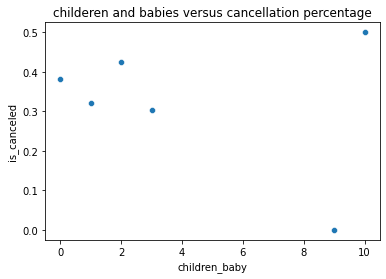

In [24]:
# children and baby
df['children_baby'] = df['children'] + df['babies']

chil_cancel_prop = df.groupby(['children_baby'])['is_canceled'].sum()/df.groupby(['children_baby'])['is_canceled'].count()

chil_cancel_prop_df = chil_cancel_prop.to_frame().reset_index()
sns.scatterplot(x=chil_cancel_prop_df['children_baby'], y=chil_cancel_prop_df['is_canceled']).set(title='childeren and babies versus cancellation percentage')
plt.show()

### 2.3 Evaluation

Comparing `is_canceled` with orginal data features and pre-processed features in terms of their correlations, we can see a clear increase for the value of correlations, which means the effectiveness of our feature preprocessing and selection steps.

In [25]:
# correlations matrix
df.corr().iloc[0,:]

is_canceled                          1.000000
lead_time                            0.302014
arrival_date_year                    0.034337
arrival_date_week_number             0.013073
arrival_date_day_of_month           -0.003738
stays_in_weekend_nights             -0.002997
stays_in_week_nights                 0.023442
adults                               0.059896
children                             0.008077
babies                              -0.033271
is_repeated_guest                   -0.088764
previous_cancellations               0.108711
previous_bookings_not_canceled      -0.054476
booking_changes                     -0.143607
agent                               -0.089626
company                             -0.027685
days_in_waiting_list                 0.052316
adr                                  0.057488
required_car_parking_spaces         -0.199040
total_of_special_requests           -0.233793
month_class                          0.071453
country_prt                       

### 2.4 Subset for future modelling

Excluding the features that we mentioned above, the subset of features are listed below.

In [26]:
column_names = ['is_canceled', 'lead_time', 'month_class', 'adults', 'country_prt', 'distribution_channel_class', 
                'is_repeated_guest', 'previous_cancellations_class', 'reserved_equal_assigned', 'booking_changes_class',
                'No_Deposit', 'Non_Refund', 'Refundable', 'have_days_in_wl', 'Contract', 'Group', 'Transient', 'Transient-Party',
                'required_car_parking_spaces_class', 'total_of_special_requests']
len(column_names)

20

In [27]:
df_final = df.loc[:, column_names]
df_final

,is_canceled,lead_time,month_class,adults,country_prt,distribution_channel_class,is_repeated_guest,previous_cancellations_class,reserved_equal_assigned,booking_changes_class,No_Deposit,Non_Refund,Refundable,have_days_in_wl,Contract,Group,Transient,Transient-Party,required_car_parking_spaces_class,total_of_special_requests
0,0,342,1,2,1,0,0,0,1,1,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0
1,0,737,1,2,1,0,0,0,1,1,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0
2,0,7,1,1,0,0,0,0,0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0
3,0,13,1,1,0,0,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0
4,0,14,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117244,0,468,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,1
117245,0,244,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,2
117246,0,244,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,2
117247,0,90,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0


## 3. Model Fitting and Tuning

We mainly compared **logistic regression method** and **decision tree method**. There are two main reasons why we rejected logistic regression model, and ended up with using decision tree method.
1. From the results of their application, the score of logistic regression method, with using best parameters found by GridSearchCV, are even lower than the score of the model using default decision tree parameters.
2. Most features in our dataset are binary types (0 and 1), the decision tree would give a better performance on this type of data.

However, one of the most obvious properties for **decision tree algorithm** is that it is more likely to overfit as it uses the greedy algorithm. To avoid this problem, general methods include re-selecting data features, and choosing hyper parameters effectively, i.e., **max_depth**, **min_samples_leaf**, etc. We did our model building and refinement accordingly.

We initially applied the simplest decision tree to the dataset, and we selected the most important features according to the ***feature_importances_***. As the default decision tree produces a large max_depth of tree that can cause potential overfitting to the model, we targeted to find out the best max_depth, by comparing the score graph of the train set and validation set and finding the best figure which could obtain a best score for the validation set. By using such a max_depth, we used **GridSearchCV** to find out some other optimal parameters. The reason why we did not put the parameter max_depth into GridSearchCV is that GridSearchCV uses the train set and will always choose a larger value for this parameter to get a higher score, which cannot avoid overfitting. 

We ended up with a model with **gini** criterion, **46** min_samples_leaf, and with **best** option as the splitter.


### 3.1 Data Splitting

We split the dataset into **train set, valid set, and test set**. Train set are used in traning the model; valid set are used in calculating the validation scores, so that we could find best parameters without overfitting the model; test set are used in our final model for testing the performance of our model.

In [29]:
# drop one attribute of one-hot-encoded variables
df_final_ = df_final.copy()

# split data into 3 parts
train_valid_df, test_df = train_test_split(df_final_, test_size = 0.2, random_state = 42, shuffle = True)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2, random_state = 42, shuffle = True)

In [30]:
output = 'is_canceled'
y_train = train_df.loc[:,output]
X_train = train_df.drop(output, axis = 1)

y_valid = valid_df.loc[:,output]
X_valid = valid_df.drop(output, axis = 1)

y_test = test_df.loc[:,output]
X_test = test_df.drop(output, axis = 1)

### 3.2 Decision Tree

### 3.2.1 Baseline Model Building

We started with the simplest decision tree, and the unspecified Decision Tree Classifier has a default max_depth 44, while with a score of approximately 0.9 on the training data, and 0.823 on the validation data. The cross validation score with 5 folds gives us 0.816 for train data, and 0.797 for validation data. The **feature_importances_** are listed below.

`lead_time`, `Non_Refund`, `country_prt` have an importance over 0.1, while the rest features take a small importance.

In [39]:
# initial model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [40]:
print(clf.get_depth())
print(clf.score(X_train, y_train))
print(clf.score(X_valid, y_valid))

44
0.8999663775132809
0.8230674054548389


In [41]:
print(cross_val_score(clf, X_train, y_train, cv = 5).mean())
print(cross_val_score(clf, X_valid, y_valid, cv = 5).mean())

0.8155604868536077
0.7972991516668179


In [42]:
sorted([*zip(X_train.columns.tolist(), clf.feature_importances_)], key = lambda t:t[1], reverse = True)

[('lead_time', 0.38576681379226535),
 ('Non_Refund', 0.17612487743247365),
 ('country_prt', 0.11791022254465917),
 ('reserved_equal_assigned', 0.060209928266857136),
 ('total_of_special_requests', 0.05582895614562213),
 ('adults', 0.03439507786791518),
 ('booking_changes_class', 0.032455150636973774),
 ('required_car_parking_spaces_class', 0.02765072398359483),
 ('month_class', 0.024477181909185707),
 ('distribution_channel_class', 0.022453009101872),
 ('previous_cancellations_class', 0.02026936093398041),
 ('Transient-Party', 0.01114033581116518),
 ('Transient', 0.010091793535071582),
 ('have_days_in_wl', 0.008677331309886897),
 ('is_repeated_guest', 0.007436164362026493),
 ('Contract', 0.0035183262106490394),
 ('Group', 0.0010269064537218315),
 ('Refundable', 0.0003361687743474038),
 ('No_Deposit', 0.0002316709277323955)]

### 3.2.2 Model Refinement

For the model refinement part, we firstly removed some less important features that was filtered by the raw model. Features with an importance less than 0.03 are removed from our model. By using the default max_depth of 42, the score of train data is 0.852, and the score of validation data is 0.813. The cross validation score of the train set and validation set are similar, both are around 0.8. Although the number of features were reduced, the performance of this model is maintained.

In [43]:
# let's try delete some unimportant features using a treshold of 0.03
df_final2 = df_final.copy()
df_final2.drop(columns=['Group', 'Refundable', 'No_Deposit', 'Contract', 'Transient-Party', 
                        'have_days_in_wl', 'is_repeated_guest', 'Transient',
                        'required_car_parking_spaces_class', 'month_class',
                        'distribution_channel_class', 'previous_cancellations_class'],
               inplace = True)

# split data into 3 parts
train_valid_df2, test_df2 = train_test_split(df_final2, test_size = 0.2, random_state = 42, shuffle = True)
train_df2, valid_df2 = train_test_split(train_valid_df2, test_size = 0.2, random_state = 42, shuffle = True)


y_train2 = train_df2.loc[:,output]
X_train2 = train_df2.drop(output, axis = 1)

y_valid2 = valid_df2.loc[:,output]
X_valid2 = valid_df2.drop(output, axis = 1)

y_test2 = test_df2.loc[:,output]
X_test2 = test_df2.drop(output, axis = 1)

In [44]:
clf2 = DecisionTreeClassifier(random_state=42)
clf2.fit(X_train2, y_train2)

print(clf2.get_depth())

42


In [45]:
print(clf2.score(X_train2, y_train2))
print(clf2.score(X_valid2, y_valid2))

0.8515096496536884
0.813007692721502


In [46]:
print(cross_val_score(clf2, X_train2, y_train2, cv = 5).mean())
print(cross_val_score(clf2, X_valid2, y_valid2, cv = 5).mean())

0.8045188622150494
0.7924577523012986


---

0.8170963326113261


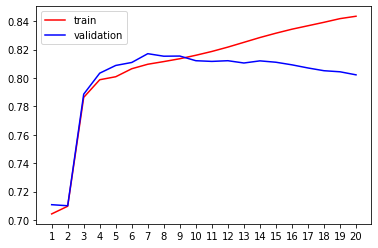

In [47]:
# have a look at the influence of the hyper parameter `max_depth`

tr = []
te = []
for i in range(20):
    clf = DecisionTreeClassifier(random_state = 42, max_depth = i+1, criterion = "entropy")
    clf = clf.fit(X_train2, y_train2)
    
    score_tr = clf.score(X_train2, y_train2)
    score_te = cross_val_score(clf, X_valid2, y_valid2, cv = 5).mean()
    
    tr.append(score_tr)
    te.append(score_te)

print(max(te))
plt.plot(range(1, 21), tr, color = "red", label = "train")
plt.plot(range(1, 21), te, color = "blue", label = "validation")
plt.xticks(range(1, 21))
plt.legend()
plt.show()

We then explored the optimal **max_depth**, i.e. we want to find the depth the tree will reach when its purity reaches the maximum, while avoiding overfitting of the model. We then calculated the fitting score of the training data, and the cross validation score of the validation data, and then the graph of tree depth versus scores is displayed above. 

The red line shows the score of the training data, which will always increase as the tree depth keeps split. However, the score of validation data reaches a maximum at depth = 7, and it means that the model will start to overfit with a depth > 7. Therefore, we decided max_depth=7.

In [48]:
# grid search with cross validation
parameter = {'splitter':('best', 'random'),
             'criterion':('gini', 'entropy'),
             'min_samples_leaf':[*range(1, 50, 3)]}

clf = DecisionTreeClassifier(random_state = 42, max_depth = 7)
GS = GridSearchCV(clf, parameter, cv = 5)

GS.fit(X_train2, y_train2)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=7, random_state=42),
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': [1, 4, 7, 10, 13, 16, 19, 22, 25,
                                              28, 31, 34, 37, 40, 43, 46, 49],
                         'splitter': ('best', 'random')})

In [49]:
print(GS.best_params_)

{'criterion': 'gini', 'min_samples_leaf': 46, 'splitter': 'best'}


We used gridsearchCV to find our optimal parameters for our model, with max_depth=7, and we ended up with using **gini** as our criterion, the optimal min_samples_leaf will be **46**, and **best** as our splitter option.

In [50]:
# use the best parameters to build a new model
clf_new = DecisionTreeClassifier(random_state=42, criterion='gini', min_samples_leaf=46, splitter='best', max_depth = 7)
clf_new.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=46, random_state=42)

In [51]:
print(clf_new.score(X_train2, y_train2))
print(clf_new.score(X_valid2, y_valid2))
print(cross_val_score(clf_new, X_train2, y_train2, cv = 5).mean())
print(cross_val_score(clf_new, X_valid2, y_valid2, cv = 5).mean())

0.8096160312016677
0.8172575178869224
0.80845941765853
0.8163969740240926


Hence, the model is built with parameters **criterion='gini', min_samples_leaf=46, splitter='best', max_depth = 7**,
and the score of training set is approximately 0.81, the score of validation set is even higher: 0.817. The cross validation with 5 folds score of training set is 0.808, and the score of validation set id 0.816. The scores of validation data are even higher than the training data, which showed us the reliability of our model.


In [52]:
# show feature importance
sorted([*zip(X_train2.columns.tolist(), clf_new.feature_importances_)], key = lambda t:t[1], reverse = True)

[('Non_Refund', 0.3036222256685849),
 ('lead_time', 0.2650566126859949),
 ('country_prt', 0.20254868885232158),
 ('reserved_equal_assigned', 0.10441490569675774),
 ('total_of_special_requests', 0.06316127815234619),
 ('booking_changes_class', 0.04908020070434991),
 ('adults', 0.012116088239644952)]

In [53]:
# test
print(clf_new.score(X_test2, y_test2))

print(cross_val_score(clf_new, X_test2, y_test2, cv = 5).mean())

0.8117145808228611
0.8072387400751211


In [55]:
# # the code here could be used to plot the decision tree, as the plot is very large, we did not include it in our final report.
# feature_name = X_train2.columns.tolist()
# dot_data = export_graphviz(clf_new, feature_names=feature_name, class_names = ['not canceled', 'canceled'],
#                            filled = True, rounded = True)
# graph = graphviz.Source(dot_data)
# graph.render("Tree")
# graph

The **feature importance** is listed above, in the order from high to low. We can see that `Non_Refund`, `lead_time`, `country_prt`, `reserved_equal_assigned` take an importance > 0.1.

We also tested our final model using the test set with the score equal to 0.812, and the cross validation score equal to 0.807. We could compare this score with the score of train set and valid set. We can see all of them have a stable score at almost more than 0.8. Hence we have reasons to believe the model is accurate and reliable.

We omitted the plot of the decision tree in our final report as it is too large.

## 4. Discussion & Conclusions


In conclusion, we have a final model, using decision tree method, with parameters **criterion='gini', min_samples_leaf=46, splitter='best', max_depth = 7**.

The most important features are listed, in the order from high to low:

**`Non_Refund`, `lead_time`, `country_prt`, `reserved_equal_assigned`, `total_of_special_requests`, `booking_changes_class`, ` adults`**.

1. For guests who has a `deposit_type = Non_Refund`, the definition of Non_Refund is mentioned in the report: "the payment was equal or exceeded the total cost of stay, the value is set as 'Non Refund". It seems to be reasonable, as guests would not want to pay the money in advance of their booking, or they do not want to pay more than what is deserved. **Hence, guests with a Non_Refund deposit type have a higher cancellation probability.**

2. `Lead time` is the number of days from the time they book to the time of arrival to the hotel. This should affect the cancellation probability highly, as a bigger lead time could give the guest time to change their travel plan; and for a smaller lead time, the guest will not have a lot of choices as time is approaching. **Hence, and guests with larger lead time will have a higher cancellation probability.**
3. `country_prt` indicates if the guest is from the Portgual or from other countries. The two hotels are located in Portgual, and it is reasonable to think that Portuguese will be more familiar with the city, and they have the option to change their plans frequently. For people who are travelling abroad, either on business or on holiday, they will book hotels carefully, and they are less likely to change their plans once they made the decision, as the international tickets can be expensive. **Hence, guests from PRT have a higher cancellation probability.**
4. `reserved_equal_assigned` shows if the booked room type is the same as the assigned room type. Usually when the hotel assign different type of room to the guest, they will assign an advanced room type. We could understand that if the guest was assigned a higher level room, they will be happy and are less likely to cancel the booking, unless they have to change their travel plan. **Hence, guests who are assigned the same room type as their booked room type have a higher cancellation probability.**
5. For `total_of_special_requests`, this records the number of times the guests asking for special service to the hotel. As the guests request more to the hotel, they will stick with the hotel, because they will need to repeat their requests again if they need to change to another hotel. **Hence, guests with no or fewer special requests have a higher cancellation probability.**
6. Similar to total of special requests, `booking_changes_class` functions the same. If the guest chose to change their booking, they would be more likely to change the booking again if needed, instead of switching to another hotel. **Hence, guests with no booking changes have a higher cancellation probability.**
7. `adults` with a group over 8 have a very high cancellation percentage. Guests with a group over 8 are rare, and if they cancel, the cancellation percentage for this group size will be as high as 1, this is caused by data imbalance (tiny sample size). Future research needs to be conducted in this feature. **Based on current dataset, guests with a large group of people have a higher cancellation probability.**


Based on our testing of the dataset, the score of test set is high, and it is to the score of validation set and score of train set. Therefore, it is reasonable to believe that for new coming dataset, the model will have the same performance and accuracy.

---

With an prediction accuracy of 0.8, if we have a total of 1000 rooms, 800 are booked as normal, an

The error are classified as 
**type I error**: we think the guest will cancel, but they did not cancel the booking. Then the room is double booked, so the hotel either need to pay some compensation to one group of the guests, or they need to assign a higher level of room to the guests. This type of error cause directly loss to the profit of the hotel. To quantify the loss more convinently, we considered giving compensation and assigning a higher level of room are the same amount of loss, i.e., the profit of this room.

**type II error**: we think the guest will not cancel, but they canceled the booking. Then we lost the profit of this room.

Assume we have a total of 100 booking orders, if 80 of them are predicted accurately based on our model accuracy, i.e. if the prediction is accurate that they will cancel the booking, then we still have profit of these rooms because we have booked these rooms to other guest; or the prediction is accurate that they did not cancel the booking, then we have the profit of these rooms. In conclusion, we could guarantee the profit of these 80 orders.

If the profit of an order is \$100, then these 80 orders have a profit of 80\*\$100 = \$8000. The type I error and type II error will cause a loss of 20\*\$100 = \$2000. So the total profit will be \$6000.

---

We need to pay more attention to **type I error**, because in such a situation, we may not only have to pay higher compensation to the guests, but also such thing will cause damage to the reputation of the hotel.